# Part3: Q5 / Q6 / Q7

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
import math
from numpy import random
import statistics as stat

In [2]:
# -- assignment 1 --
import numpy as np
from urllib import request
import gzip
import pickle
import os

def load_synth(num_train=60_000, num_val=10_000, seed=0):
    """
    Load some very basic synthetic data that should be easy to classify. Two features, so that we can plot the
    decision boundary (which is an ellipse in the feature space).
    :param num_train: Number of training instances
    :param num_val: Number of test/validation instances
    :param num_features: Number of features per instance
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data with 2 features as a numpy floating point array, and the corresponding classification labels as a numpy
     integer array. The second contains the test/validation data in the same format. The last integer contains the
     number of classes (this is always 2 for this function).
    """
    np.random.seed(seed)

    THRESHOLD = 0.6
    quad = np.asarray([[1, -0.05], [1, .4]])

    ntotal = num_train + num_val

    x = np.random.randn(ntotal, 2)

    # compute the quadratic form
    q = np.einsum('bf, fk, bk -> b', x, quad, x)
    y = (q > THRESHOLD).astype(np.int)

    return (x[:num_train, :], y[:num_train]), (x[num_train:, :], y[num_train:]), 2

def load_mnist(final=False, flatten=True):
    """
    Load the MNIST data.
    :param final: If true, return the canonical test/train split. If false, split some validation data from the training
       data and keep the test data hidden.
    :param flatten: If true, each instance is flattened into a vector, so that the data is returns as a matrix with 768
        columns. If false, the data is returned as a 3-tensor preserving each image as a matrix.
    :return: Two tuples and an integer: (xtrain, ytrain), (xval, yval), num_cls. The first contains a matrix of training
     data and the corresponding classification labels as a numpy integer array. The second contains the test/validation
     data in the same format. The last integer contains the number of classes (this is always 2 for this function).
     """

    if not os.path.isfile('mnist.pkl'):
        init()

    xtrain, ytrain, xtest, ytest = load()
    xtl, xsl = xtrain.shape[0], xtest.shape[0]

    if flatten:
        xtrain = xtrain.reshape(xtl, -1)
        xtest  = xtest.reshape(xsl, -1)

    if not final: # return the flattened images
        return (xtrain[:-5000], ytrain[:-5000]), (xtrain[-5000:], ytrain[-5000:]), 10

    return (xtrain, ytrain), (xtest, ytest), 10

# Numpy-only MNIST loader. Courtesy of Hyeonseok Jung
# https://github.com/hsjeong5/MNIST-for-Numpy

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [3]:
class NeuralNet:
    def __init__(self, W1, W2, b1, b2, lr):
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2
        self.learn = lr
    
    def softmax(self, x):
        return np.exp(x) / np.sum(np.exp(x), axis=0)

    
    def sigmoid(self, X):
        X = np.clip(X, -500, 500 )
        return 1 / (1 + np.exp(-X))
    
    
    def forward(self, x, nn):
        Z1 = np.dot(self.W1, x) + self.b1
        A1 = nn.sigmoid(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = nn.softmax(Z2)
        return Z1, A1, A2
    
    
    def backprop(self, A1, A2, x, y):
        m = x.shape[1]
        dz2 = A2 - y
        dW2 = np.dot(dz2, A1.T) * (1/m)
        db2 = np.sum(dz2, axis =1, keepdims = True) * (1/m)
        dZ1 = np.dot(self.W2.T, dz2) * (1 - np.power(A1, 2))
        dW1 = np.dot(dZ1, x.T) * (1/m)
        db1 = np.sum(dZ1, axis =1, keepdims = True) * (1/m)
        return dW1, dW2, db1, db2

    def update_weights(self, dW1, dW2, db1, db2):
        self.W1 = self.W1 - self.learn * dW1
        self.b1 = self.b1 - self.learn * db1
        self.W2 = self.W2 - self.learn * dW2
        self.b2 = self.b2 - self.learn * db2

    def loss(self, y_pred, y):
        return -np.log(y_pred[np.where(y)])

In [4]:
def cycle(nn, x, y, val=False):
    #training data
    Z1, A1, A2 = nn.forward(x, nn)
    loss = nn.loss(A2, y)
    if val==False:
        dW1, dW2, db1, db2 = nn.backprop(A1, A2, x, y)
        nn.update_weights(dW1, dW2, db1, db2)
    return loss

def sgd(nn, xtrain, ytrain, xval, yval, epochs):
    loss_list_xtrain = []
    loss_list_xval = []
    epoch_list = []
    acc_list = []
    
    for i in range(1,epochs+1,):
        print('Epoch=', i)
        loss_xtrain = []
        loss_xval = []
        
        print('...training...')
        for x, y in zip(xtrain.T, ytrain.T):
            x = np.array(x).reshape(x.shape[0],1)
            y = np.array(y).reshape(y.shape[0],1)
            loss_xt = cycle(nn, x, y)
            loss_xtrain.append(loss_xt)
    
        print('...validating...')
        for x, y in zip(xval.T, yval.T):
            xval = np.array(x).reshape(x.shape[0],1)
            yval = np.array(y).reshape(y.shape[0],1)
            loss_val = cycle(nn, xval, yval, val=True)
            loss_xval.append(loss_val)

        loss_list_xtrain.append(np.average(loss_xtrain))
        loss_list_xval.append(np.average(loss_xval))
        epoch_list.append(i)
        
    return loss_list_xtrain, loss_list_xval, epoch_list

def count_trues(nn, val_list, true_index):
    pred_index = [np.argmax(i) for i in val_list]
    count = 0
    for i in range(len(true_index)):
        if pred_index[i]==true_index[i]:
            count += 1
    return count

def get_accuracy(nn, xval, y_or):
    val_list = []
    print(xval.T)
    for x in xval.T:
        xval = np.array(x).reshape(x.shape[0],1)
        Z1, A1, A2 = nn.forward(xval, nn)
        val_list.append(A2)
    count = count_trues(nn, val_list, y_or)
    return count/len(y_or)

In [5]:
#data
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()
y_original = yval

xtrain = np.array(xtrain).T
xval = np.array(xval).T

y_train = np.zeros((ytrain.shape[0], ytrain.max()+1), dtype=np.float32)
y_train[np.arange(ytrain.shape[0]), ytrain] = 1
y_val = np.zeros((yval.shape[0], yval.max()+1), dtype=np.float32)
y_val[np.arange(yval.shape[0]), yval] = 1

ytrain = np.array(y_train).T
yval = np.array(y_val).T

#normalize
xtrain = xtrain/255
xval = xval/255

print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

Download complete.
Save complete.
(784, 55000) (10, 55000) (784, 5000) (10, 5000)


In [6]:
#initialize(nn-> inputs-300-10)
W1 = np.random.randn(300, xtrain.shape[0])
W2 = np.random.randn(10, 300)
b1 = np.zeros([300,1])
b2 = np.zeros([10,1])
lr = 0.01
nn = NeuralNet(W1, W2, b1, b2, lr)
epochs = 5

loss_list_xtrain, loss_list_xval, epoch_list = sgd(nn, xtrain, ytrain, xval, yval, epochs)

Epoch= 1
...training...
...validating...
Epoch= 2
...training...
...validating...
Epoch= 3
...training...
...validating...
Epoch= 4
...training...
...validating...
Epoch= 5
...training...
...validating...


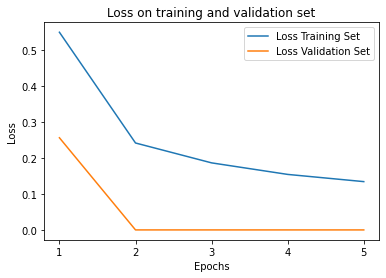

In [7]:
y1 = loss_list_xtrain
x1 = epoch_list
plt.plot(x1, y1, label = "Loss Training Set")
y2 = loss_list_xval
x2 = epoch_list
plt.plot(x2, y2, label = "Loss Validation Set")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss on training and validation set')
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
plt.legend()
plt.savefig('Q7,1: training and validation loss')
plt.show()

# Q6 Minibatch Gradient Descent

In [ ]:
#run this data block before runnning the bathc gradient descent code block
(xtrain, ytrain), (xval, yval), num_cls = load_mnist()
y_original = yval

xtrain = np.array(xtrain).T
xval = np.array(xval).T

y_train = np.zeros((ytrain.shape[0], ytrain.max()+1), dtype=np.float32)
y_train[np.arange(ytrain.shape[0]), ytrain] = 1
y_val = np.zeros((yval.shape[0], yval.max()+1), dtype=np.float32)
y_val[np.arange(yval.shape[0]), yval] = 1

ytrain = np.array(y_train).T
yval = np.array(y_val).T

#normalize
xtrain = xtrain/255
xval = xval/255

print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

In [ ]:
def make_batches(data, labels, batch_size,shuffle=True):
        n_features, n_samples = data.shape

        batch_indices = np.arange(0, n_samples, batch_size)

        if shuffle:
            permutation = np.random.permutation(n_samples)
            data = data[:, permutation]
            labels = labels[:, permutation]
        
        for i in range(len(xtrain)):
            for i in batch_indices:
                X = data[:, i:i + batch_size]
                Y = labels[:, i:i + batch_size]
            return X, Y
def shuffle(x, y):
    p = np.random.permutation(len(y))
    return x[p], y[p]

def minibatch_gd(nn, xtrain, ytrain, xval, yval, minibatch_size, epochs):
    
    loss_list_xtrain = []
    loss_list_xval = []
    epoch_list = []
    
    for i in range(1,epochs+1,):
        print('Epoch=', i)
        loss_xtrain = []
        loss_xval = []
        
        #loop and create batches:
        for j in range(0, xtrain.shape[1], minibatch_size):
            xbatch, ybatch = make_batches(xtrain, ytrain, 500, shuffle=True)
            #train on batches
            loss_xt = cycle(nn, xbatch, ybatch)
            loss_xtrain.append(loss_xt)
            for x, y in zip(xval.T, yval.T):
                xval = np.array(x).reshape(x.shape[0],1)
                yval = np.array(y).reshape(y.shape[0],1)
                loss_val = cycle(nn, xval, yval, val=True)
                loss_xval.append(loss_val)
            loss_list_xtrain.append(np.average(loss_xtrain))
            loss_list_xval.append(np.average(loss_xval))
        epoch_list.append(i)
        

    return loss_list_xtrain, loss_list_xval, epoch_list
random.seed(1)
W1 = np.random.randn(300, xtrain.shape[0])
W2 = np.random.randn(10, 300)
b1 = np.zeros([300,1])
b2 = np.zeros([10,1])
lr = 0.01
nn = NeuralNet(W1, W2, b1, b2, lr)
epochs = 5
minibatch_size = 100
batch_loss_list_xtrain, batch_loss_list_xval, epoch_list = minibatch_gd(nn, xtrain, ytrain, xval, yval, minibatch_size, epochs)     

In [ ]:
x_axis = []
for i in range(1,len(batch_loss_list_xtrain)+1,1):
    x_axis.append(i*(epochs/len(batch_loss_list_xtrain)))


In [ ]:
y1 = batch_loss_list_xtrain
x1 = x_axis
plt.plot(x1, y1, label = "Training")

y2 = batch_loss_list_xval
x2 = x_axis
plt.plot(x2, y2, label = "validation")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during epochs with batch gradient descent')
plt.xticks(np.arange(0, 6, 1.0))
plt.legend()
plt.savefig('Q6,50batchloss')
plt.show()

In [ ]:
acc_minibatch = get_accuracy(nn, xval, y_original)
print(acc_minibatch)

# Q7.1

In [ ]:
#initialize(nn-> inputs-300-10)
loss_xtrain_av=[]
loss_xval_av=[]
for j in range(1,5):
    W1 = np.random.randn(300, xtrain.shape[0])
    W2 = np.random.randn(10, 300)
    b1 = np.zeros([300,1])
    b2 = np.zeros([10,1])
    lr = 0.01
    nn = NeuralNet(W1, W2, b1, b2, lr)
    epochs = 5
    loss_list_xtrain, loss_list_xval, epoch_list = sgd(nn, xtrain, ytrain, xval, yval, epochs)
    av_loss_xtrain = []
    av_loss_xval = []

    for i in range(len(loss_list_xtrain)):
        av_loss_xtrain.append(loss_list_xtrain[i])
        av_loss_xval.append(loss_list_xval[i])
    
    loss_xtrain_av.append(av_loss_xtrain)
    loss_xval_av.append(av_loss_xval)



In [ ]:
y1 = loss_xval_av[0]
x1 = epoch_list
plt.plot(x1, y1, label = "run1")

y2 = loss_xval_av[1]
x2 = epoch_list
plt.plot(x2, y2, label = "run2")

y3 = loss_xval_av[2]
x3 = epoch_list
plt.plot(x3, y3, label = "run3")

y4 = loss_xval_av[3]
x4 = epoch_list
plt.plot(x4, y4, label = "run4")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average loss of 4 runs on validation set')
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
plt.legend()
plt.savefig('Q7,2 validation loss of 4 runs')
plt.show()

In [ ]:
std_epoch1 = []
std_epoch2 = []
std_epoch3 = []
std_epoch4 = []
std_epoch5 = []
for i in loss_xval_av:
    std_epoch1.append(i[0])
    std_epoch2.append(i[1])
    std_epoch3.append(i[2])
    std_epoch4.append(i[3])
    std_epoch5.append(i[4])
    
std1 = np.std(std_epoch1)
std2 = np.std(std_epoch2)
std3 = np.std(std_epoch3)
std4 = np.std(std_epoch4)
std5 = np.std(std_epoch5)
stds = [std1, std2, std3, std4, std5]

In [ ]:
y1 = stds
x1 = epoch_list
plt.plot(x1, y1, label = "std")

plt.xlabel('Epochs')
plt.ylabel('Standaard deviation')
plt.title('Standard deviation of the average loss during of the four different runs')
plt.xticks(np.arange(min(x1), max(x1)+1, 1.0))
plt.legend()
plt.savefig('Q7,2 std')
plt.show()

# 7.2

In [ ]:
#initialize(nn-> inputs-300-10)
loss_xtrain_av=[]
loss_xval_av=[]
acc = []
lr = 0.002
for j in range(1,11):
    W1 = np.random.randn(300, xtrain.shape[0])
    W2 = np.random.randn(10, 300)
    b1 = np.zeros([300,1])
    b2 = np.zeros([10,1])
    nn = NeuralNet(W1, W2, b1, b2, lr)
    epochs = 5
    loss_list_xtrain, loss_list_xval, epoch_list = sgd(nn, xtrain, ytrain, xval, yval, epochs)
    av_loss_xtrain = []
    av_loss_xval = []

    for i in range(len(loss_list_xtrain)):
        av_loss_xtrain.append(loss_list_xtrain[i])
        av_loss_xval.append(loss_list_xval[i])
    
    loss_xtrain_av.append(av_loss_xtrain)
    loss_xval_av.append(av_loss_xval)
    acc.append(get_accuracy(nn, xval, y_original))
    lr += 0.002

In [ ]:
learningrates = [0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02]

In [ ]:
y1 = acc
x1 = learningrates
plt.plot(x1, y1, label = "accuracy")

plt.xlabel('Learning Rates')
plt.ylabel('Accuracy')
plt.title('Accuracy of diffrent learning reates after 5 epochs on the evaluation data')
plt.xticks(np.arange(min(x1), max(x1)+0.002, 0.002))
plt.yticks(np.arange(0.94, 0.97, 0.01))
plt.legend()
plt.savefig('new:Q7,3 LearningRates')
plt.show()

In [ ]:

y1 = loss_xval_av[0][:3:]
x1 = epoch_list[:3:]
plt.plot(x1, y1, label = "0.002")

y2 = loss_xval_av[1][:3:]
x2 = epoch_list[:3:]
plt.plot(x2, y2, label = "0.004")

y3 = loss_xval_av[2][:3:]
x3 = epoch_list[:3:]
plt.plot(x3, y3, label = "0.006")

y4 = loss_xval_av[3][:3:]
x4 = epoch_list[:3:]
plt.plot(x4, y4, label = "0.008")

y5 = loss_xval_av[4][:3:]
x5 = epoch_list[:3:]
plt.plot(x5, y5, label = "0.010")

y6 = loss_xval_av[5][:3:]
x6 = epoch_list[:3:]
plt.plot(x6, y6, label = "0.012")

y7 = loss_xval_av[6][:3:]
x7 = epoch_list[:3:]
plt.plot(x7, y7, label = "0.014")

y8 = loss_xval_av[7][:3:]
x8 = epoch_list[:3:]
plt.plot(x8, y8, label = "0.016")

y9 = loss_xval_av[8][:3:]
x9 = epoch_list[:3:]
plt.plot(x7, y7, label = "0.018")

y10 = loss_xval_av[9][:3:]
x1 = epoch_list
x10 = epoch_list
plt.plot(x8, y8, label = "0.020")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during 5 epochs of with different learning rates')
plt.yticks(np.arange(0, 0.45, 0.05))
plt.xticks(np.arange(min(x1), 3.5, 0.5))
plt.legend()
plt.savefig('Q7,3 Learning and losses')
plt.show()

# 7.4

In [ ]:
#data
(xtrain, ytrain), (xval, yval), num_cls = load_mnist(final=True)
print(xtrain)
print(ytrain)
print(xval)
print(yval)
y_original = yval

xtrain = np.array(xtrain).T
xval = np.array(xval).T

y_train = np.zeros((ytrain.shape[0], ytrain.max()+1), dtype=np.float32)
y_train[np.arange(ytrain.shape[0]), ytrain] = 1
y_val = np.zeros((yval.shape[0], yval.max()+1), dtype=np.float32)
y_val[np.arange(yval.shape[0]), yval] = 1

ytrain = np.array(y_train).T
yval = np.array(y_val).T

#normalize
xtrain = xtrain/255
xval = xval/255

print(xtrain.shape, ytrain.shape, xval.shape, yval.shape)

In [ ]:
#initialize(nn-> inputs-300-10)
W1 = np.random.randn(300, xtrain.shape[0])
W2 = np.random.randn(10, 300)
b1 = np.zeros([300,1])
b2 = np.zeros([10,1])
lr = 0.01
nn = NeuralNet(W1, W2, b1, b2, lr)
epochs = 5
loss_list_xtrain, loss_list_xval, epoch_list = sgd(nn, xtrain, ytrain, xval, yval, epochs)
acc_final = get_accuracy(nn, xval, y_original)
print(acc_final)